In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

import torch
from torch import nn
import joblib

In [3]:
df = pd.read_csv("Datasets/plant_growth_dataset.csv")
df.head()

,plant_species,date,plant_age_days,temperature,humidity,soil_moisture,soil_ph,light_intensity,height_cm,leaf_area_cm2,health_score
0,Arive-Dantu,2023-01-01,10,24.354431,52.994030,36.632859,7.046809,15589.751987,9.361922,26.532273,0.738861
1,Arive-Dantu,2023-01-02,10,23.921513,53.483883,37.028936,6.960871,15683.670310,9.371922,30.669019,0.706514
2,Arive-Dantu,2023-01-03,16,23.548990,52.616118,38.361623,7.015171,15798.653790,9.381922,33.182690,0.668551
3,Arive-Dantu,2023-01-04,20,23.818069,52.247005,39.367779,7.057316,16366.642237,9.391922,28.648229,0.641078
4,Arive-Dantu,2023-01-05,16,23.891465,54.646367,38.633777,7.012412,16514.012045,9.401922,29.153371,0.605280


In [4]:
df['plant_species'].value_counts()

Arive-Dantu      937
Basale           937
Betel            937
Crape_Jasmine    937
Curry            937
Mint             937
Neem             937
Oleander         937
Parijata         937
Peepal           937
Pomegranate      937
Rasna            937
Rose_apple       937
Roxburgh_fig     937
Sandalwood       937
Tulsi            937
Name: plant_species, dtype: int64

In [5]:
print("Null counts per column:\n", df.isnull().sum())
print("\nTotal null entries:", df.isnull().sum().sum())

# Drop rows with missing values (paper works with small clean dataset).
df = df.dropna().reset_index(drop=True)

# Remove duplicates
dups = df.duplicated().sum()
print("Duplicates found:", dups)
df = df.drop_duplicates().reset_index(drop=True)
print("Shape after dropna & dedupe:", df.shape)

Null counts per column:
 plant_species      0
date               0
plant_age_days     0
temperature        0
humidity           0
soil_moisture      0
soil_ph            0
light_intensity    0
height_cm          0
leaf_area_cm2      0
health_score       0
dtype: int64

Total null entries: 0
Duplicates found: 0
Shape after dropna & dedupe: (14992, 11)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14992 entries, 0 to 14991
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   plant_species    14992 non-null  object 
 1   date             14992 non-null  object 
 2   plant_age_days   14992 non-null  int64  
 3   temperature      14992 non-null  float64
 4   humidity         14992 non-null  float64
 5   soil_moisture    14992 non-null  float64
 6   soil_ph          14992 non-null  float64
 7   light_intensity  14992 non-null  float64
 8   height_cm        14992 non-null  float64
 9   leaf_area_cm2    14992 non-null  float64
 10  health_score     14992 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 1.3+ MB


<Figure size 1500x500 with 0 Axes>

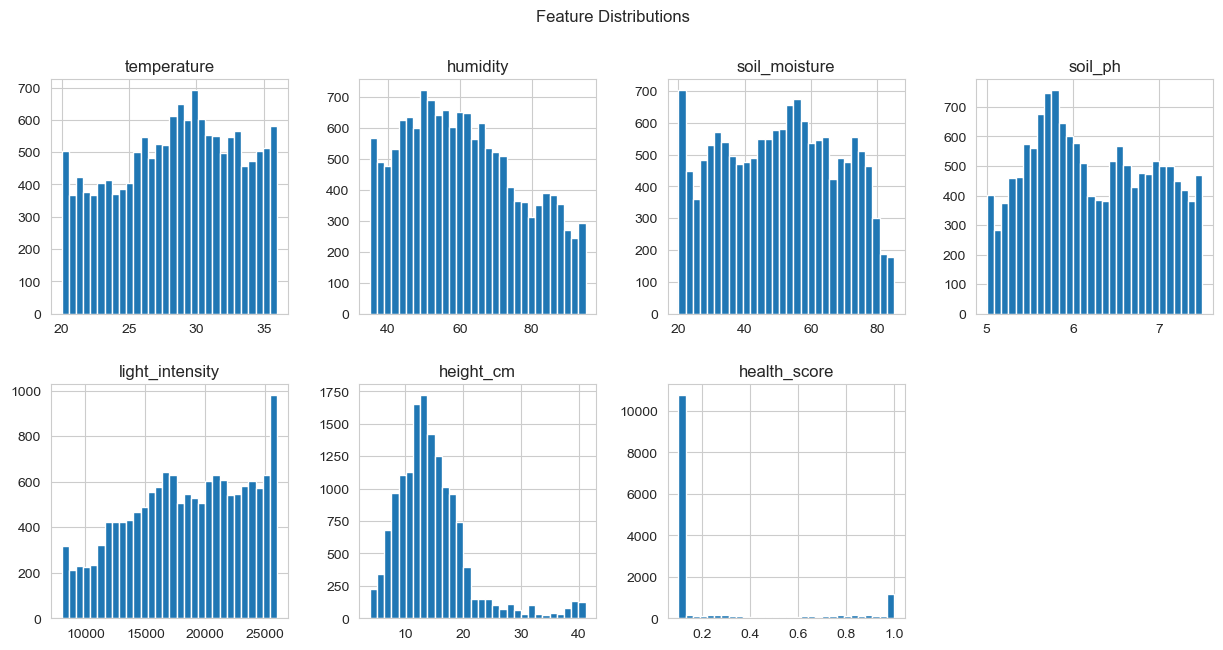

In [7]:
plt.figure(figsize=(15, 5))
df[['temperature','humidity','soil_moisture','soil_ph','light_intensity','height_cm','health_score']].hist(bins=30, layout=(2,4), figsize=(15,7))
plt.suptitle("Feature Distributions")
plt.show()

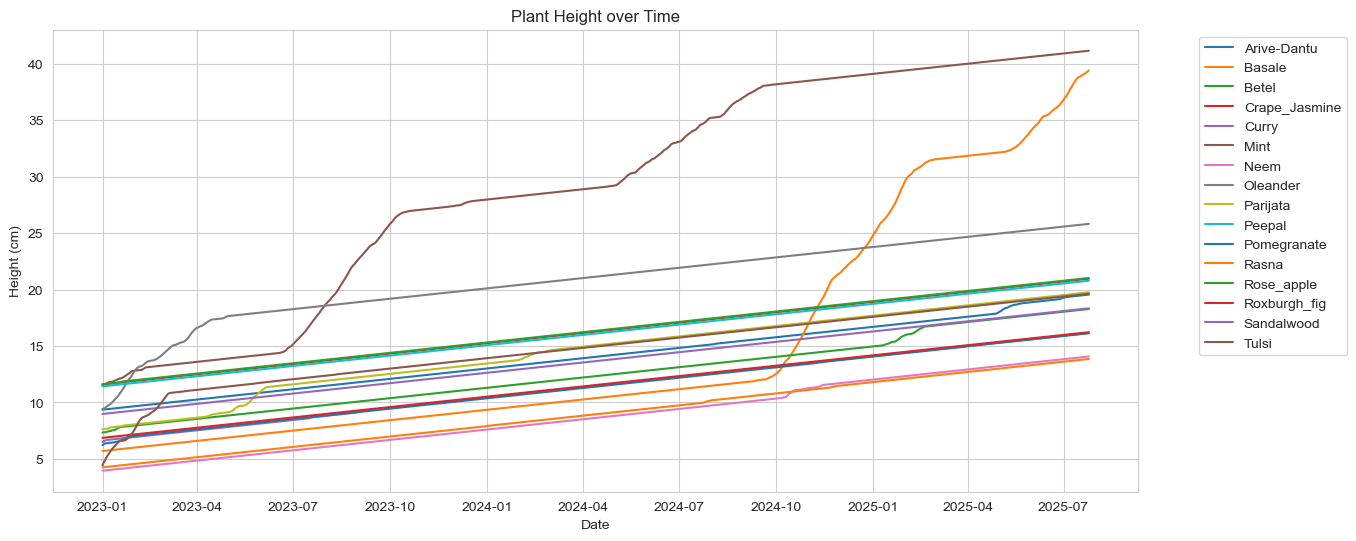

In [8]:
plt.figure(figsize=(14,6))
for plant in df['plant_species'].unique():
    sub = df[df['plant_species']==plant]
    plt.plot(pd.to_datetime(sub['date']), sub['height_cm'], label=plant)
plt.xlabel("Date")
plt.ylabel("Height (cm)")
plt.title("Plant Height over Time")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

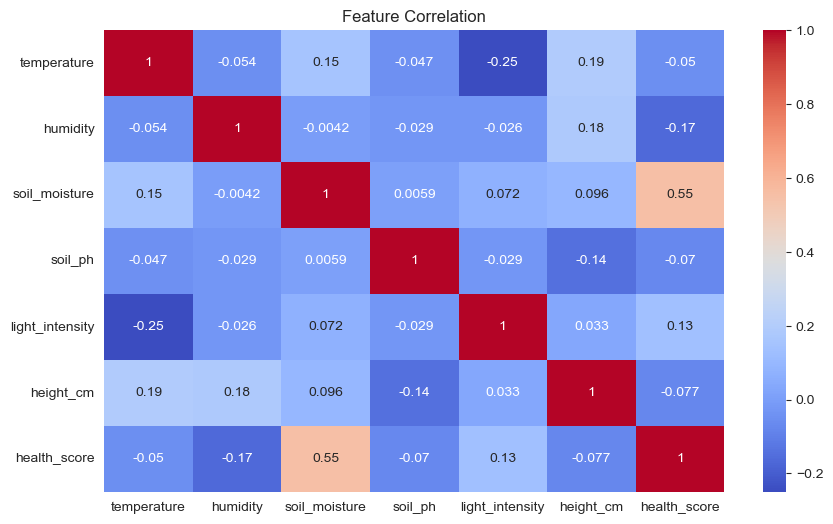

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['temperature','humidity','soil_moisture','soil_ph','light_intensity','height_cm','health_score']].corr(),
            annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

In [10]:
plant = "Tulsi"
sub = df[df["plant_species"] == plant].reset_index(drop=True)

features = ["temperature", "humidity", "soil_moisture", "soil_ph", "light_intensity", "height_cm"]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(sub[features])

In [11]:
sequence_length = 30
X, Y = [], []
for i in range(len(scaled) - sequence_length):
    X.append(scaled[i:i+sequence_length])
    Y.append(scaled[i+sequence_length][5])  # height_cm

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

# train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]


In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=6, hidden_size=128, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1])
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
epochs = 1000
for e in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out.squeeze(), Y_train)
    loss.backward()
    optimizer.step()
    if e % 10 == 0:
        print(f"Epoch {e}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 0.407849
Epoch 10, Loss: 0.038452
Epoch 20, Loss: 0.022650
Epoch 30, Loss: 0.013286
Epoch 40, Loss: 0.007809
Epoch 50, Loss: 0.003558
Epoch 60, Loss: 0.002838
Epoch 70, Loss: 0.001928
Epoch 80, Loss: 0.001504
Epoch 90, Loss: 0.001243
Epoch 100, Loss: 0.000970
Epoch 110, Loss: 0.000734
Epoch 120, Loss: 0.000539
Epoch 130, Loss: 0.000414
Epoch 140, Loss: 0.000352
Epoch 150, Loss: 0.000306
Epoch 160, Loss: 0.000265
Epoch 170, Loss: 0.000224
Epoch 180, Loss: 0.000187
Epoch 190, Loss: 0.000155
Epoch 200, Loss: 0.000131
Epoch 210, Loss: 0.000114
Epoch 220, Loss: 0.000103
Epoch 230, Loss: 0.000096
Epoch 240, Loss: 0.000090
Epoch 250, Loss: 0.000085
Epoch 260, Loss: 0.000141
Epoch 270, Loss: 0.000099
Epoch 280, Loss: 0.000079
Epoch 290, Loss: 0.000073
Epoch 300, Loss: 0.000068
Epoch 310, Loss: 0.000064
Epoch 320, Loss: 0.000062
Epoch 330, Loss: 0.000059
Epoch 340, Loss: 0.000056
Epoch 350, Loss: 0.000054
Epoch 360, Loss: 0.000052
Epoch 370, Loss: 0.000049
Epoch 380, Loss: 0.0000

In [14]:
torch.save(model.state_dict(), "Models/growth_forecast_lstm.pth")

In [15]:
model.eval()

LSTMModel(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [16]:
with torch.no_grad():
    y_pred = model(X).squeeze().numpy()
    y_true = Y.numpy()

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"\n===== LSTM Evaluation for {plant} height =====")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2:   {r2:.4f}")


===== LSTM Evaluation for Tulsi height =====
MAE:  0.0097
RMSE: 0.0166
R2:   0.9915


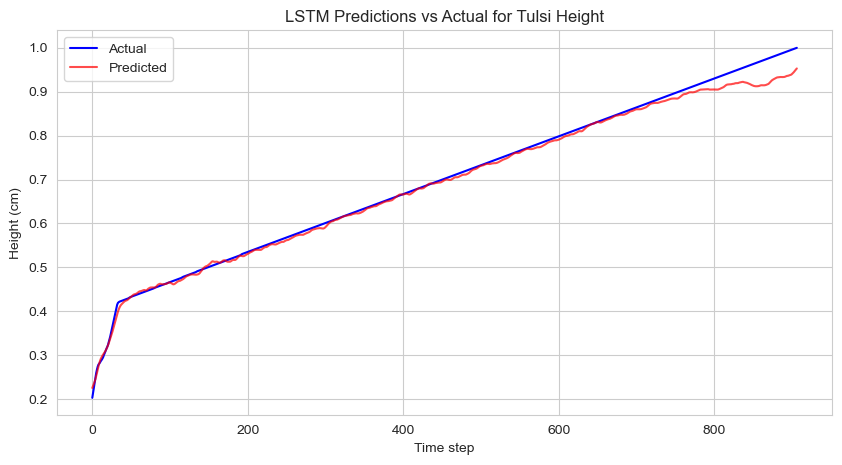

In [17]:
# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(y_pred, label="Predicted", color='red', alpha=0.7)
plt.title(f"LSTM Predictions vs Actual for {plant} Height")
plt.xlabel("Time step")
plt.ylabel("Height (cm)")
plt.legend()
plt.grid(True)
plt.show()


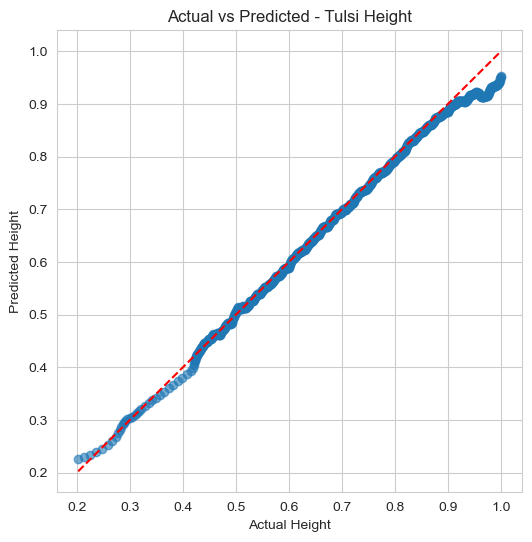

In [18]:
# Scatter plot to visualize correlation
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Height")
plt.ylabel("Predicted Height")
plt.title(f"Actual vs Predicted - {plant} Height")
plt.grid(True)
plt.show()

In [19]:
import joblib
# after: scaled = scaler.fit_transform(sub[features])
joblib.dump(scaler, "Models/lstm_scaler.sav")


['Models/lstm_scaler.sav']